In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

from pandas import Series
from pandas import DataFrame
from typing import Tuple

from tqdm import tnrange#, tqdm_notebook
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## Texture syntesis with Hilbert curves 

In [6]:
from packages.hilbert_curve.hilbert import HilbertCurve

We consider an N-dimensional hypercube of side length 2^p. This hypercube contains 2^{N p} unit hypercubes (2^p along each dimension). The number of unit hypercubes determine the possible discrete distances along the Hilbert curve (indexed from 0 to 2^{N p} - 1).

## I. Image sampling and processing functions

### Luminicity based grayscale conversion

In [7]:
def convert_to_grayscale(image: np.array)-> np.array:
    """Converts RGB image to grayscale image preserving perceived luminocity""" 
    return 0.299 * image[:,:,0] + 0.587 * image[:,:,1] + 0.114 * image[:,:,2]

In [9]:
from matplotlib import pyplot as plt
image = plt.imread('data/vangoghmuseum-s0025V1962-3840.png')

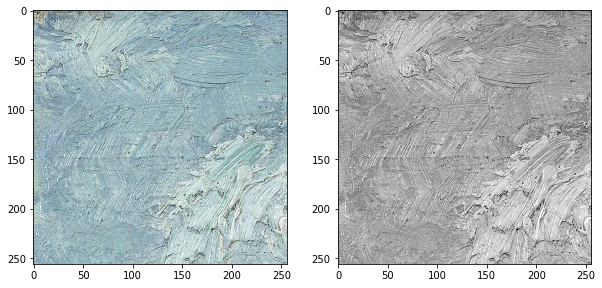

In [21]:
image = image[:256,:256, :]
gimage = convert_to_grayscale(image)


fig=plt.figure(figsize=(10,10))
fig.add_subplot(1, 2, 1)
plt.imshow(image)
fig.add_subplot(1, 2, 2)
plt.imshow(gimage, cmap ='gray')


## Image to vector based on Hilbert curve mapping

In [28]:
def image_to_hcurve(image: np.array) -> Tuple[np.array, np.array]:
    """
    
    For simplicity expects image size to be square and a power of two. If this 
    is not the case, it selects a largest subimage satisfying this restriction. 
    
    """
    assert len(image.shape) == 2 or len(image.shape) == 3, "We process only RGB and grayscale images"
        
    p = int(np.log2(np.min(image.shape[:2])))
    hilbert_curve = HilbertCurve(p, 2)
    idx = np.array([hilbert_curve.coordinates_from_distance(i) for i in range(4**p)])
    
    if len(image.shape) == 3:
        curve = image[idx[:, 0], idx[:, 1], :]
    elif len(image.shape) == 2:
        curve = image[idx[:, 0], idx[:, 1]]
    
    return curve, idx


def hcurve_to_image(curve: np.array, idx: np.array=None)-> np.array:
    assert idx is None or curve.shape[0] == idx.shape[0], 'Transformation index'

    p = int(0.5 * np.log2(curve.shape[0]))

    if idx is None:
        hilbert_curve = HilbertCurve(p, 2)
        idx = np.array([hilbert_curve.coordinates_from_distance(i) for i in range(4**p)])
    
    image = np.full([2**p, 2**p, 3], np.nan)
    image[idx[:, 0], idx[:, 1], :] = curve
    return image

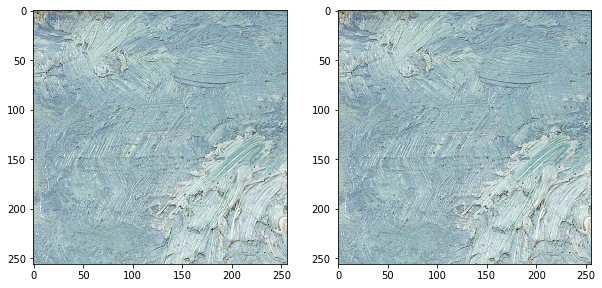

In [29]:
curve, idx = image_to_hcurve(image)

fig=plt.figure(figsize=(10,10))
fig.add_subplot(1, 2, 1)
plt.imshow(image)
fig.add_subplot(1, 2, 2)
plt.imshow(hcurve_to_image(curve, idx))

## II. Inferring the transition matric for Markov chain  

In [65]:
gcurve, idx = image_to_hcurve(gimage)


### Lag matrix

In [120]:
df = (DataFrame(curve, columns = ['curve'])
      .transform(lambda x: round(x * 256).astype(int))
      .assign(lag_1 = lambda df: df['curve'].shift(1),
              lag_2 = lambda df: df['curve'].shift(2),
              lag_3 = lambda df: df['curve'].shift(3),
              lag_4 = lambda df: df['curve'].shift(4),
              lag_5 = lambda df: df['curve'].shift(5),
              lag_6 = lambda df: df['curve'].shift(6),
              lag_7 = lambda df: df['curve'].shift(7),
              lag_8 = lambda df: df['curve'].shift(8))
      .iloc[8:].astype(int))
head(df)

,curve,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8
8,97,112,143,164,183,149,148,156,147
9,155,97,112,143,164,183,149,148,156
10,156,155,97,112,143,164,183,149,148
11,191,156,155,97,112,143,164,183,149
12,151,191,156,155,97,112,143,164,183


In [131]:
g = df[['curve', 'lag_1']].groupby(['curve','lag_1'])
tmp = g.apply(lambda x: len(x)).reset_index().rename(columns = {0:'count'})

In [138]:
tmp.groupby(['lag_1']).apply(lambda df: df.assign(pr = (df['count'] + 1) / (df['count'] + 1).sum())).reset_index(drop=True)

,curve,lag_1,count,pr
0,138,29,1,1.000000
1,143,33,1,1.000000
2,152,45,1,0.500000
3,183,45,1,0.500000
4,101,49,1,1.000000
5,73,51,1,0.500000
6,144,51,1,0.500000
7,111,52,1,1.000000
8,175,53,1,1.000000
9,57,55,1,1.000000


In [135]:
tmp.loc[tmp['count'] > 1].sum()

curve    1230139
lag_1    1230038
count      61918
dtype: int64

In [114]:
g = df[['curve', 'lag_1']].groupby(['lag_1'])
df = (g.apply(lambda df : 
        df.groupby('curve')
        .count()
        .rename(columns={'lag_1': 'count'})
        .reset_index())
 .reset_index('lag_1'))


In [116]:
df.loc[df['count'] > 1]

,lag_1,curve,count
0,91,114,2
2,91,168,2
9,95,209,2
11,97,203,2
10,99,171,2
3,103,106,2
6,103,144,2
12,103,190,2
8,104,192,3
6,105,181,2


In [105]:
g.get_group(225).groupby('curve').count().rename(columns={'lag_1': 'count'}).reset_index()

,curve,count
0,135,1
1,146,1
2,161,1
3,167,1
4,174,1
5,177,2
6,181,1
7,185,3
8,186,1
9,188,2


In [101]:
g.count()

,curve
lag_1,
29,1
33,1
45,2
49,1
51,2
52,1
53,1
55,1
57,1


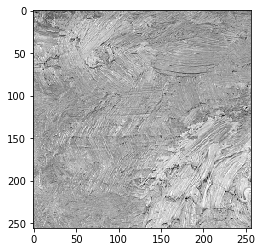

In [42]:
plt.imshow(convert_to_grayscale(image), cmap ='gray')

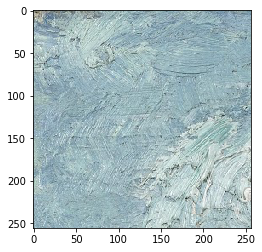

In [13]:
idx = np.array([hilbert_curve.coordinates_from_distance(i) for i in range(4**p)])

In [14]:
 curve = image[idx[:, 0], idx[:, 1], :]

In [15]:
int(0.5 * np.log2(curve.shape[0]))

5

In [16]:
boo = np.full([2**p, 2**p], np.nan)

In [20]:
curve.shape
idx[:, 0]


array([ 0,  0,  1, ..., 30, 31, 31])

In [19]:
boo[idx[:, 0], idx[:, 1] :]).shape

TypeError: only integer scalar arrays can be converted to a scalar index

In [78]:
p = int(np.log2(16))
size = 2**p - 1

In [68]:
hilbert_curve = HilbertCurve(p, 2)

In [92]:
idx = np.array([hilbert_curve.coordinates_from_distance(i) for i in range(4**p)])

In [95]:
curve = image[idx[:, 0], idx[:, 1], :]

In [101]:
uhuu = np.full([2**p, 2**p, 3], np.nan)

In [102]:
uhuu[idx[:, 0], idx[:, 1], :] = curve

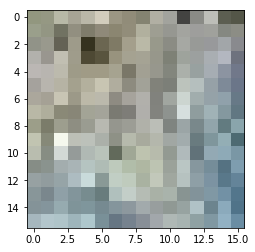

In [106]:
display(plt.imshow(uhuu))

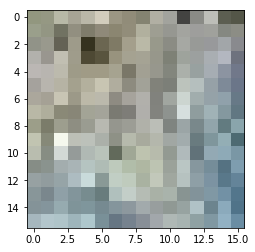

In [105]:
display(plt.imshow(image[:16, :16, :]))

In [97]:
idx[:,0]

array([ 0,  0,  1,  1,  2,  3,  3,  2,  2,  3,  3,  2,  1,  1,  0,  0,  0,
        1,  1,  0,  0,  0,  1,  1,  2,  2,  3,  3,  3,  2,  2,  3,  4,  5,
        5,  4,  4,  4,  5,  5,  6,  6,  7,  7,  7,  6,  6,  7,  7,  7,  6,
        6,  5,  4,  4,  5,  5,  4,  4,  5,  6,  6,  7,  7,  8,  9,  9,  8,
        8,  8,  9,  9, 10, 10, 11, 11, 11, 10, 10, 11, 12, 12, 13, 13, 14,
       15, 15, 14, 14, 15, 15, 14, 13, 13, 12, 12, 12, 12, 13, 13, 14, 15,
       15, 14, 14, 15, 15, 14, 13, 13, 12, 12, 11, 10, 10, 11, 11, 11, 10,
       10,  9,  9,  8,  8,  8,  9,  9,  8,  8,  9,  9,  8,  8,  8,  9,  9,
       10, 10, 11, 11, 11, 10, 10, 11, 12, 12, 13, 13, 14, 15, 15, 14, 14,
       15, 15, 14, 13, 13, 12, 12, 12, 12, 13, 13, 14, 15, 15, 14, 14, 15,
       15, 14, 13, 13, 12, 12, 11, 10, 10, 11, 11, 11, 10, 10,  9,  9,  8,
        8,  8,  9,  9,  8,  7,  7,  6,  6,  5,  4,  4,  5,  5,  4,  4,  5,
        6,  6,  7,  7,  7,  6,  6,  7,  7,  7,  6,  6,  5,  5,  4,  4,  4,
        5,  5,  4,  3,  2

In [87]:
f(np.array([0,1]).T)

ValueError: setting an array element with a sequence.

In [66]:
idx = DataFrame(list(range(4**p))
                
                , columns = ['i']).assign(a =lambda df: hilbert_curve.coordinates_from_distance(df['i']))
idx.head()                

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [60]:
 for ii in range(4**p):
    coords = hilbert_curve.coordinates_from_distance(ii)
    print(f'coords(h={ii}) = {coords}')

coords(h=0) = [0, 0]
coords(h=1) = [0, 1]
coords(h=2) = [1, 1]
coords(h=3) = [1, 0]
coords(h=4) = [2, 0]
coords(h=5) = [3, 0]
coords(h=6) = [3, 1]
coords(h=7) = [2, 1]
coords(h=8) = [2, 2]
coords(h=9) = [3, 2]
coords(h=10) = [3, 3]
coords(h=11) = [2, 3]
coords(h=12) = [1, 3]
coords(h=13) = [1, 2]
coords(h=14) = [0, 2]
coords(h=15) = [0, 3]
coords(h=16) = [0, 4]
coords(h=17) = [1, 4]
coords(h=18) = [1, 5]
coords(h=19) = [0, 5]
coords(h=20) = [0, 6]
coords(h=21) = [0, 7]
coords(h=22) = [1, 7]
coords(h=23) = [1, 6]
coords(h=24) = [2, 6]
coords(h=25) = [2, 7]
coords(h=26) = [3, 7]
coords(h=27) = [3, 6]
coords(h=28) = [3, 5]
coords(h=29) = [2, 5]
coords(h=30) = [2, 4]
coords(h=31) = [3, 4]
coords(h=32) = [4, 4]
coords(h=33) = [5, 4]
coords(h=34) = [5, 5]
coords(h=35) = [4, 5]
coords(h=36) = [4, 6]
coords(h=37) = [4, 7]
coords(h=38) = [5, 7]
coords(h=39) = [5, 6]
coords(h=40) = [6, 6]
coords(h=41) = [6, 7]
coords(h=42) = [7, 7]
coords(h=43) = [7, 6]
coords(h=44) = [7, 5]
coords(h=45) = [6, 5

In [2]:
%config IPCompleter.greedy=True